# VIX Cross Asset Volatility With Skew

In [4]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas_datareader as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Path Management

In [5]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
out_path = os.path.join(parent_path, "out")

if os.path.exists(data_path) == False: os.makedirs(data_path)
if os.path.exists(out_path) == False: os.makedirs(out_path)

# Read in Data

In [7]:
df_skew = pd.read_parquet(
    path = os.path.join(data_path, "skew.parquet"))

df_yf = pd.read_parquet(
    path = os.path.join(data_path, "yf.parquet"),
    engine = "pyarrow")

In [26]:
df_val_combined = (df_yf.rename(columns = {
    "value": "vol_value"}).
    merge(
        (df_skew.rename(
            columns = {"value": "skew_value"})), 
        how = "inner", 
        on = ["date"]).
    drop(columns = ["field"]))

In [43]:
df_skew_vix_value = (df_val_combined.query(
    "variable == 'VIX'").
    assign(new_value = lambda x: 0.5 * x.skew_value + 0.5 + x.vol_value)
    [["date", "new_value"]].
    merge(
        (df_val_combined.query(
            "variable == 'MOVE'")),
        how = "inner",
        on = ["date"])
    [["date", "new_value", "vol_value"]].
    rename(columns = {
        "new_value": "skew_vix",
        "vol_value": "move_value"}))

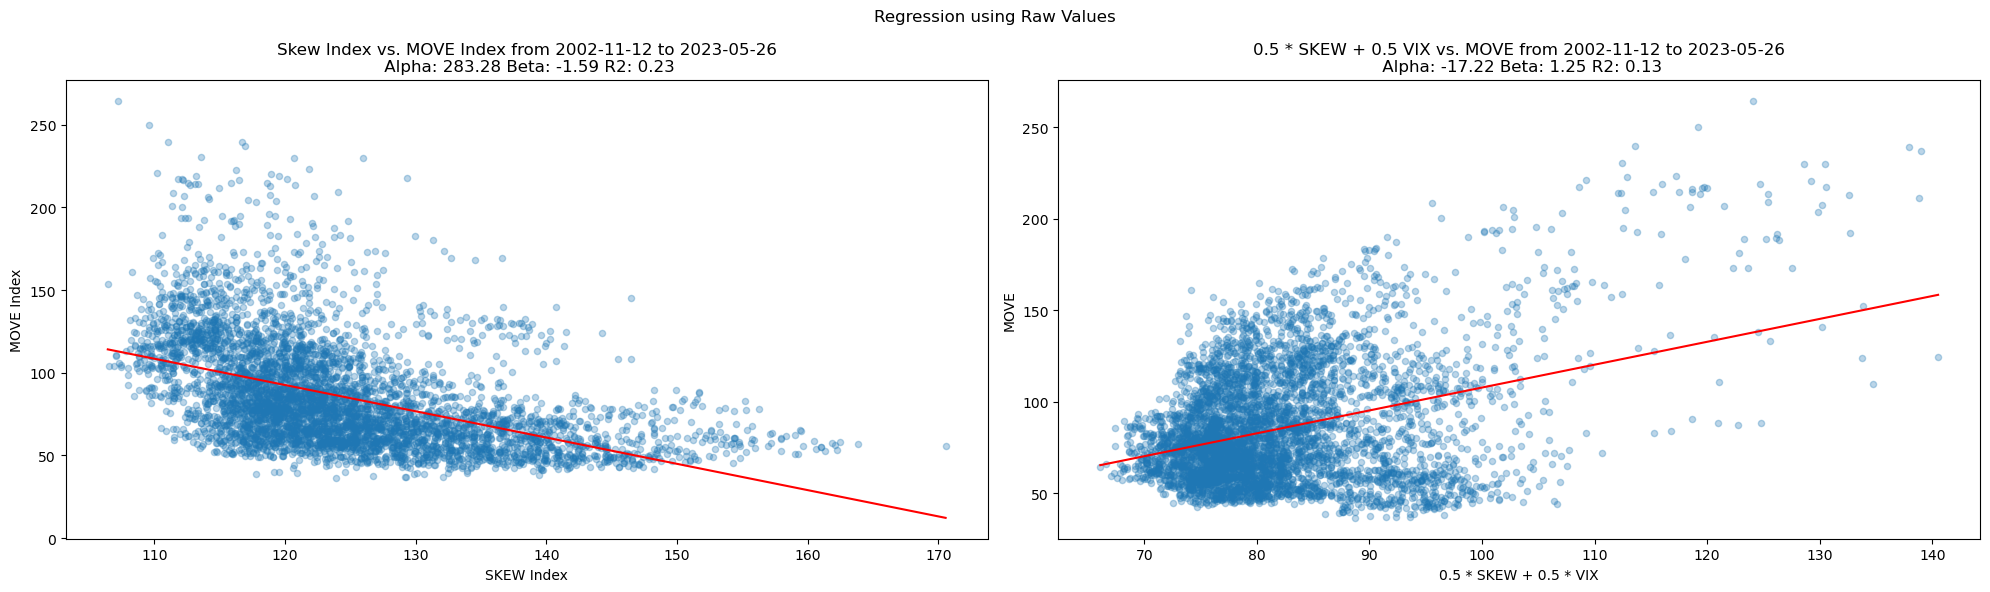

In [92]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 6))

(df_val_combined.query(
    "variable == 'MOVE'").
    plot(
        ax = axes[0],
        kind = "scatter", 
        x = "skew_value", y = "vol_value",
        alpha = 0.3,
        xlabel = "SKEW Index",
        ylabel = "MOVE Index"))

regression1 = (sm.OLS(
    endog = df_val_combined.query("variable == 'MOVE'").vol_value,
    exog = sm.add_constant(df_val_combined.query("variable == 'MOVE'").skew_value)).
    fit())

alpha1, beta1 = regression1.params
x1 = np.linspace(
    start = df_val_combined.query("variable == 'MOVE'").skew_value.min(),
    stop = df_val_combined.query("variable == 'MOVE'").skew_value.max(),
    num = 1_000)
y1 = (x1 * beta1) + alpha1
axes[0].plot(x1, y1, color = "r")
axes[0].set_title("Skew Index vs. MOVE Index from {} to {}\n Alpha: {} Beta: {} R2: {}".format(
    df_val_combined.query("variable == 'MOVE'").date.min().date(),
    df_val_combined.query("variable == 'MOVE'").date.max().date(),
    round(alpha1, 2),
    round(beta1, 2),
    round(regression1.rsquared, 2)))

(df_skew_vix_value.plot(
    ax = axes[1],
    kind = "scatter",
    x = "skew_vix", y = "move_value",
    xlabel = "0.5 * SKEW + 0.5 * VIX",
    ylabel = "MOVE",
    alpha = 0.3))


regression2 = (sm.OLS(
    endog = df_skew_vix_value.move_value,
    exog = sm.add_constant(df_skew_vix_value.skew_vix)).
    fit())
alpha2, beta2 = regression2.params
x2 = np.linspace(
    start = df_skew_vix_value.skew_vix.min(),
    stop = df_skew_vix_value.skew_vix.max(),
    num = 1_000)
y2 = (x2 * beta2) + alpha2
axes[1].plot(x2, y2, color = "r")
axes[1].set_title("0.5 * SKEW + 0.5 VIX vs. MOVE from {} to {}\n Alpha: {} Beta: {} R2: {}".format(
    df_skew_vix_value.date.min().date(),
    df_skew_vix_value.date.max().date(),
    round(alpha2, 2),
    round(beta2, 2),
    round(regression2.rsquared, 2)))

fig.suptitle("Regression using Raw Values")
plt.tight_layout()
plt.show()

# Combining all of the data

In [69]:
vol_rtns = (df_yf.pivot(
    index = "date", columns = "variable", values = "value").
    pct_change().
    reset_index().
    melt(id_vars = "date").
    dropna())

df_skew_rtns = (df_skew.drop(
    columns = ["field"]).
    pivot(index = "date", columns = "ticker", values = "value").
    pct_change().
    rename(columns = {"SKEW Index": "skew"}).
    reset_index().
    melt(id_vars = "date").
    dropna())

In [86]:
df_combined = (vol_rtns.rename(
    columns = {"value": "vol_rtns"}).
    merge(
        df_skew_rtns,
        how = "inner",
        on = ["date"]).
    rename(columns = {"value": "skew_rtns"}))

df_vix_skew_combined = (df_combined.query(
    "variable == 'VIX'").
    assign(skew_vix = lambda x: (x.skew_rtns * 0.5) + (x.vol_rtns * 0.5))
    [["date", "skew_vix"]])

In [113]:
df_skew_vix_move = (df_combined.query(
    "variable == 'MOVE'").
    merge(df_vix_skew_combined, how = "inner", on = "date")
    [["vol_rtns", "skew_vix", "date"]].
    rename(columns = {"vol_rtns": "move"}))

df_skew_move = (df_combined.query(
    "variable == 'MOVE'")
    [["date", "vol_rtns", "skew_rtns"]].
    rename(columns = {"vol_rtns": "move"}))

In [114]:
regression1 = (sm.OLS(
    endog = df_skew_vix_move.move,
    exog = sm.add_constant(df_skew_vix_move.skew_vix)).
    fit())

alpha1, beta1 = regression1.params
x1 = np.linspace(
    start = df_skew_vix_move.skew_vix.min(),
    stop = df_skew_vix_move.skew_vix.max(),
    num = 1_000)
y1 = (x1 * beta1) + alpha1
rsquared1 = regression1.rsquared

regression2 = (sm.OLS(
    endog = df_skew_move.move,
    exog = sm.add_constant(df_skew_move.skew_rtns)).
    fit())

alpha2, beta2 = regression2.params
x2 = np.linspace(
    start = df_skew_move.skew_rtns.min(),
    stop = df_skew_move.skew_rtns.max(),
    num = 1_000)
y2 = (x2 * beta2) + alpha2
rsquared2 = regression2.rsquared

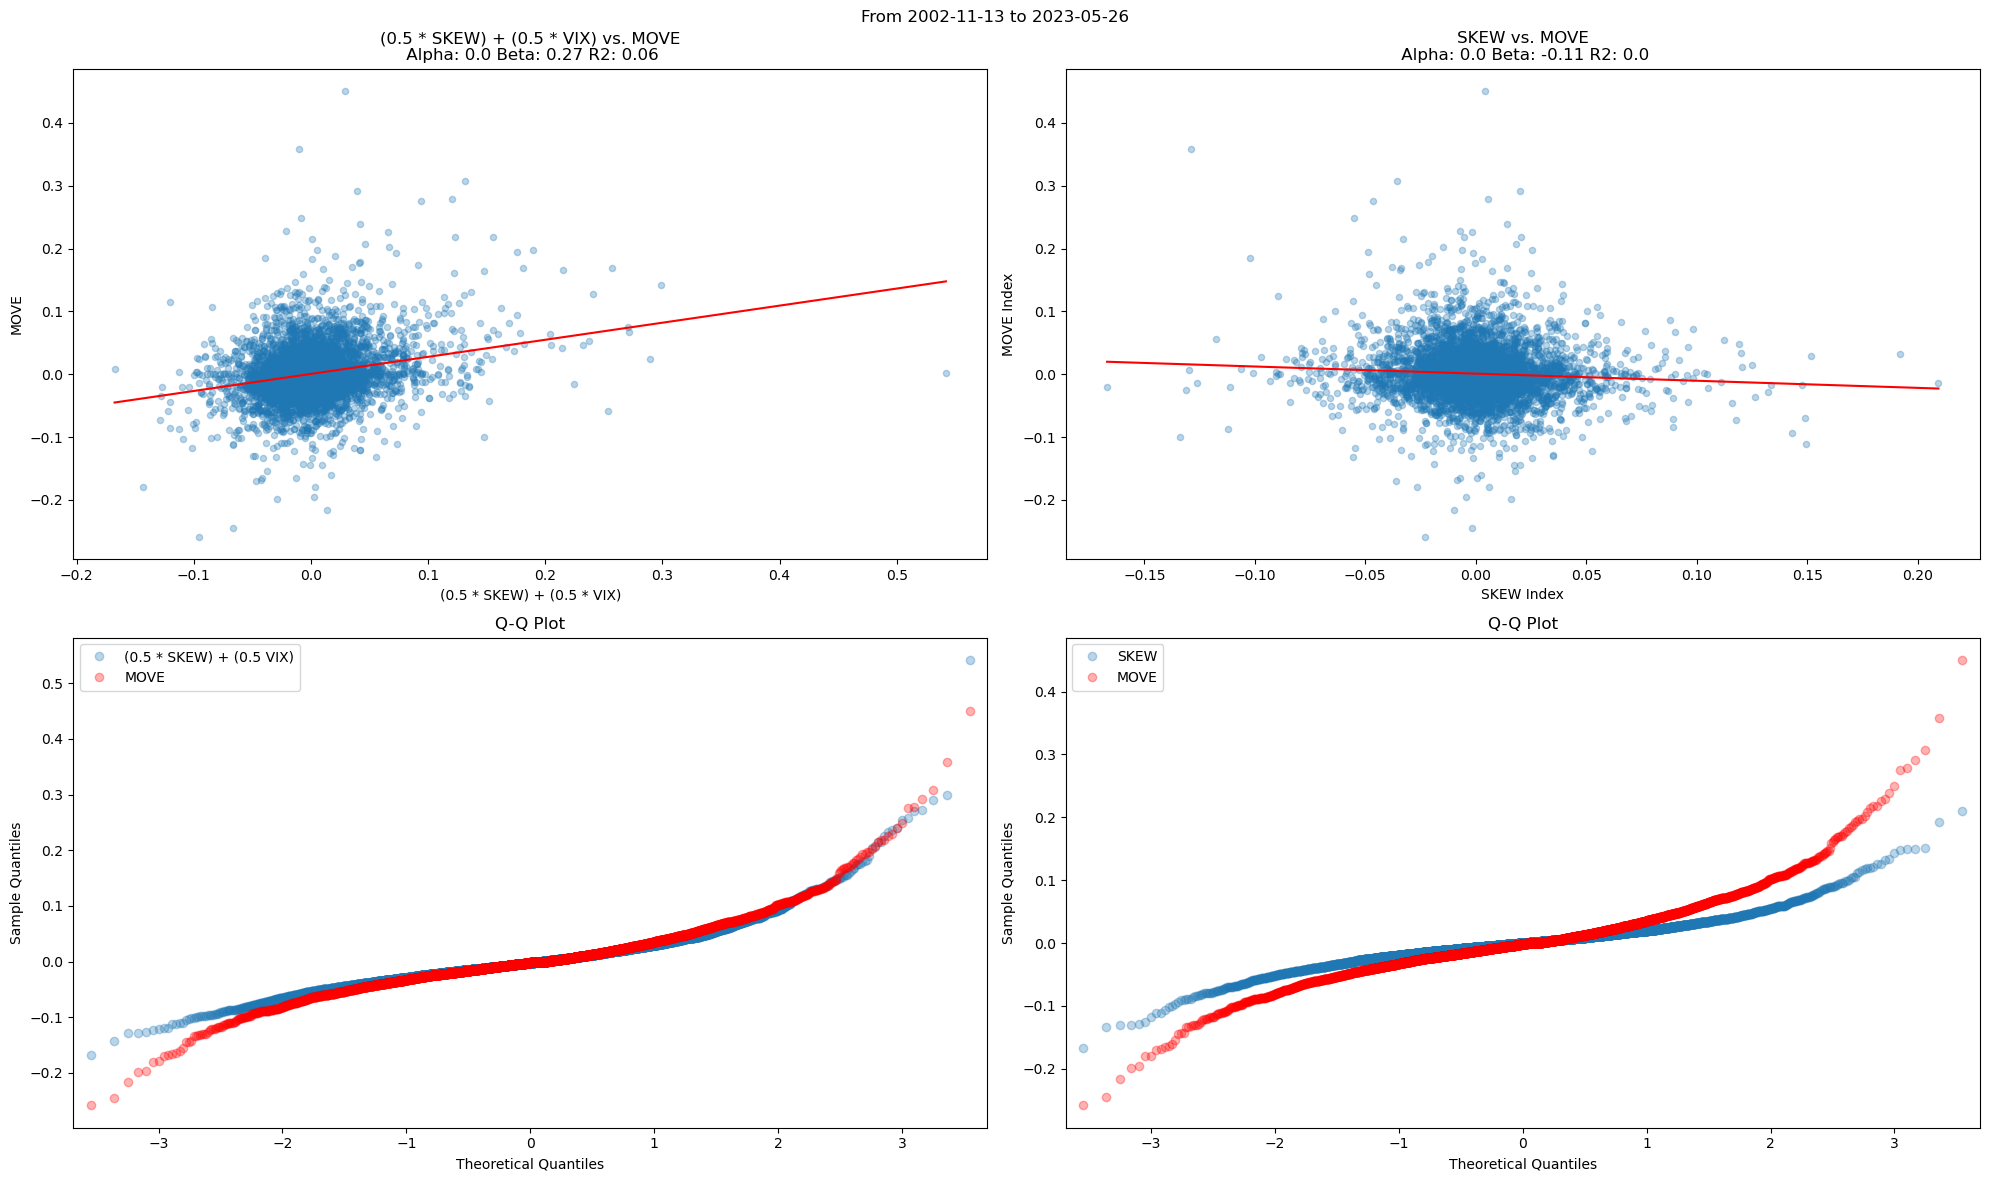

In [115]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20, 12))

(df_skew_vix_move.plot(
    ax = axes[0,0],
    kind = "scatter",
    x = "skew_vix", y = "move",
    alpha = 0.3,
    xlabel = "(0.5 * SKEW) + (0.5 * VIX)", 
    ylabel = "MOVE"))
axes[0,0].plot(x1, y1, color = "r")
axes[0,0].set_title("(0.5 * SKEW) + (0.5 * VIX) vs. MOVE\n Alpha: {} Beta: {} R2: {}".format(
    round(alpha1, 2),
    round(beta1, 2),
    round(rsquared1, 2)))

(df_skew_move.plot(
    ax = axes[0,1],
    kind = "scatter",
    x = "skew_rtns",
    y = "move",
    xlabel = "SKEW Index",
    ylabel = "MOVE Index",
    alpha = 0.3))

axes[0,1].plot(x2, y2, color = "r")
axes[0,1].set_title("SKEW vs. MOVE\n Alpha: {} Beta: {} R2: {}".format(
    round(alpha2, 2),
    round(beta2, 2),
    round(rsquared2, 2)))

_ = sm.qqplot(
    df_skew_vix_move.skew_vix,
    ax = axes[1,0],
    alpha = 0.3,
    label = "(0.5 * SKEW) + (0.5 VIX)")

_ = sm.qqplot(
    df_skew_vix_move.move,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    ax = axes[1,0],
    label = "MOVE")

_ = sm.qqplot(
    df_skew_move.skew_rtns,
    ax = axes[1,1],
    alpha = 0.3,
    label = "SKEW")

_ = sm.qqplot(
    df_skew_vix_move.move,
    markerfacecolor = "r",
    markeredgecolor = "r",
    alpha = 0.3,
    ax = axes[1,1],
    label = "MOVE")

axes[1,0].set_title("Q-Q Plot")
axes[1,0].legend()

axes[1,1].set_title("Q-Q Plot")
axes[1,1].legend()

fig.suptitle("From {} to {}".format(
    df_skew_move.date.min().date(),
    df_skew_move.date.max().date()))

plt.tight_layout()
plt.show()

In [126]:
df_move_skew = (df_val_combined.query(
    "variable == 'MOVE'").
    set_index("date")
    [["vol_value", "skew_value"]].
    rename(columns = {"vol_value": "move"}))

df_skew_vix_value = df_skew_vix_value.set_index("date")

In [139]:
df_skew_vix_value.head(3)

,skew_vix,move_value
date,,
2002-11-12,87.600,120.209999
2002-11-13,88.295,122.879997
2002-11-14,85.650,130.289993


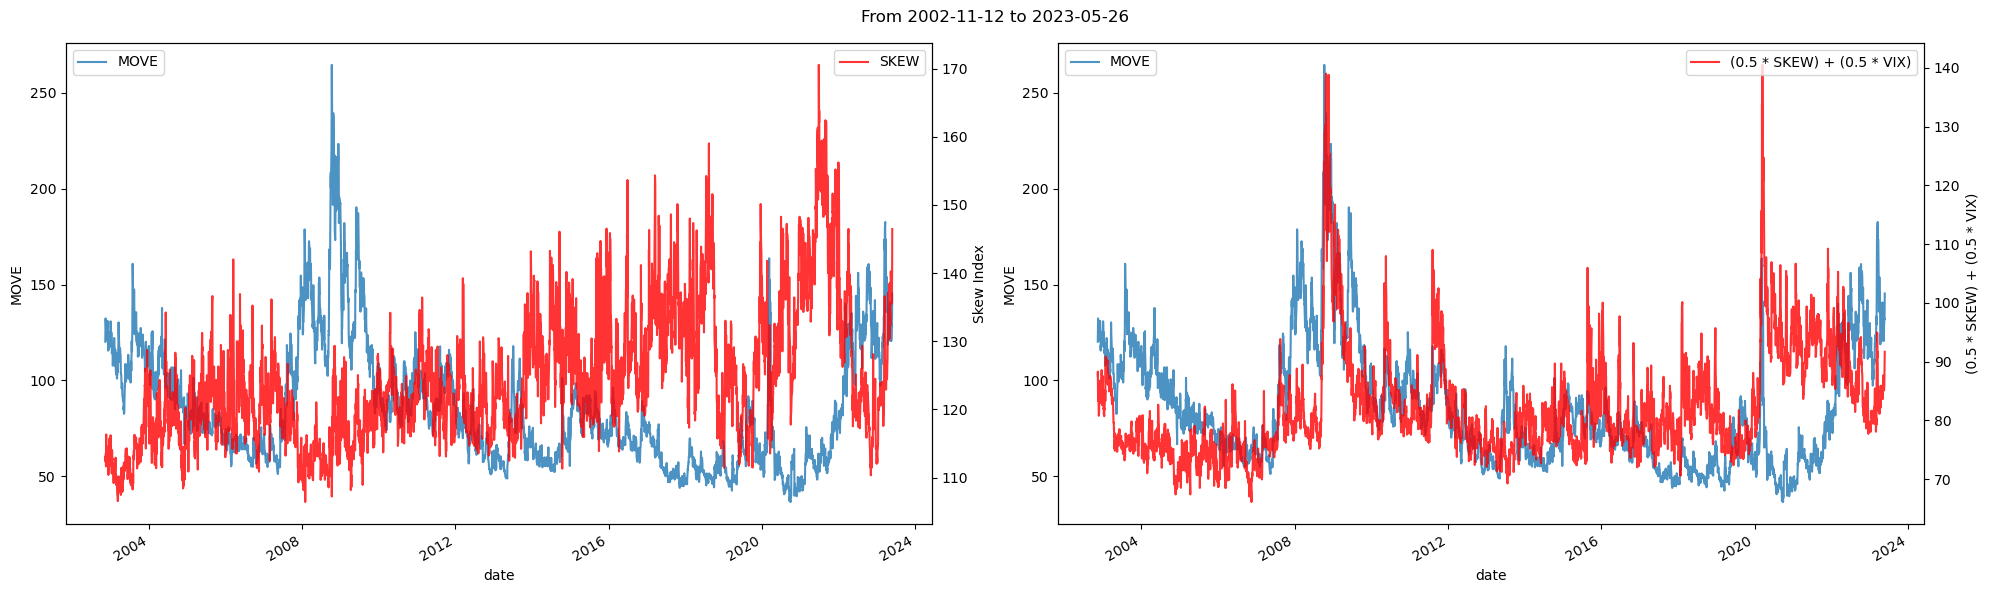

In [156]:
fig, axes = plt.subplots(ncols =2, figsize = (20, 6))

axes0_copy = axes[0].twinx()
(df_move_skew[
    ["move"]].
    rename(columns = {"move": "MOVE"}).
    plot(
        ax = axes[0],
        alpha = 0.8,
        ylabel = "MOVE"))

(df_move_skew[
    ["skew_value"]].
    rename(columns = {"skew_value": "SKEW"}).
    plot(
        ax = axes0_copy,
        ylabel = "Skew Index",
        alpha = 0.8,
        color = "red"))

axes[0].legend(loc = "upper left")
axes0_copy.legend(loc = "upper right")

axes1_copy = axes[1].twinx()
(df_skew_vix_value[
    ["move_value"]].
    rename(columns = {"move_value": "MOVE"}).
    plot(
        ax = axes[1],
        alpha = 0.8,
        ylabel = "MOVE"))

(df_skew_vix_value[
    ["skew_vix"]].
    rename(columns = {"skew_vix": "(0.5 * SKEW) + (0.5 * VIX)"}).
    plot(
        ax = axes1_copy,
        alpha = 0.8,
        color = "red",
        ylabel = "(0.5 * SKEW) + (0.5 * VIX)"))

axes[1].legend(loc = "upper left")
axes1_copy.legend(loc = "upper right")

fig.suptitle("From {} to {}".format(
    df_skew_vix_value.index.min().date(),
    df_skew_vix_value.index.max().date()))

plt.tight_layout()
plt.show()